# Covid case prediction using an infered graph (AR+Diffusion and SVAR)

## Preprocessing

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data_url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/total_cases.csv"
data_raw = pd.read_csv(data_url, index_col=0)
data_raw = data_raw.fillna(0).diff().clip(lower=0)


In [114]:
countries_europe = ['France', 'Italy', 'Spain', 'Germany', 'United Kingdom', 'Russia']
countries_nord_america = ['United States', 'Canada']
countries_asia = ['China', 'Japan', 'South Korea', 'India']
countries_south_america = ['Brazil', 'Argentina', 'Colombia', 'Chile']
countries_africa = ['South Africa', 'Egypt', 'Nigeria', 'Morocco']
countries_oceania = ['Australia', 'New Zealand']

countries = countries_europe + countries_nord_america + countries_asia + countries_south_america + countries_africa + countries_oceania
data = data_raw[countries]


In [115]:
data.index = pd.to_datetime(data.index)
data_days = data.copy()
data = data.resample('W').mean()
data = data.dropna()
data_days = data_days.dropna()
data

,France,Italy,Spain,Germany,United Kingdom,Russia,United States,Canada,China,Japan,South Korea,India,Brazil,Argentina,Colombia,Chile,South Africa,Egypt,Nigeria,Morocco,Australia,New Zealand
date,,,,,,,,,,,,,,,,,,,,,,
2020-01-26,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.750000,378.750000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2020-02-02,0.428571,0.285714,0.142857,1.428571,0.285714,0.285714,0.428571,0.142857,2077.857143,2.285714,1.714286,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.142857,0.000000
2020-02-09,0.714286,0.142857,0.142857,0.571429,1.714286,0.000000,0.571429,0.571429,3311.857143,0.571429,1.428571,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.000000
2020-02-16,0.142857,0.000000,0.000000,0.285714,0.571429,0.000000,0.285714,0.142857,4379.428571,5.142857,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000
2020-02-23,0.000000,21.714286,0.000000,0.000000,1.428571,0.000000,0.285714,0.857143,927.428571,12.714286,81.857143,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-12,3242.285714,4414.428571,1198.142857,12105.000000,3175.857143,10760.857143,36573.000000,1390.714286,0.000000,29235.142857,13158.857143,281.571429,9347.000000,456.285714,71.714286,1514.571429,72.857143,3.000000,0.000000,7.857143,2491.142857,2460.571429
2023-02-19,3275.714286,4049.571429,1005.428571,13543.142857,3661.714286,13312.142857,39028.285714,1593.857143,0.000000,20225.857143,11217.428571,119.714286,7968.428571,258.142857,118.714286,1509.857143,448.285714,4.571429,0.000000,6.857143,2479.428571,1174.285714
2023-02-26,3845.000000,4205.428571,1054.285714,15564.142857,4077.000000,12265.000000,35240.857143,1376.857143,0.000000,13433.428571,9858.428571,166.428571,4692.714286,167.428571,100.714286,2002.142857,147.714286,0.000000,0.000000,8.857143,2666.142857,1299.142857


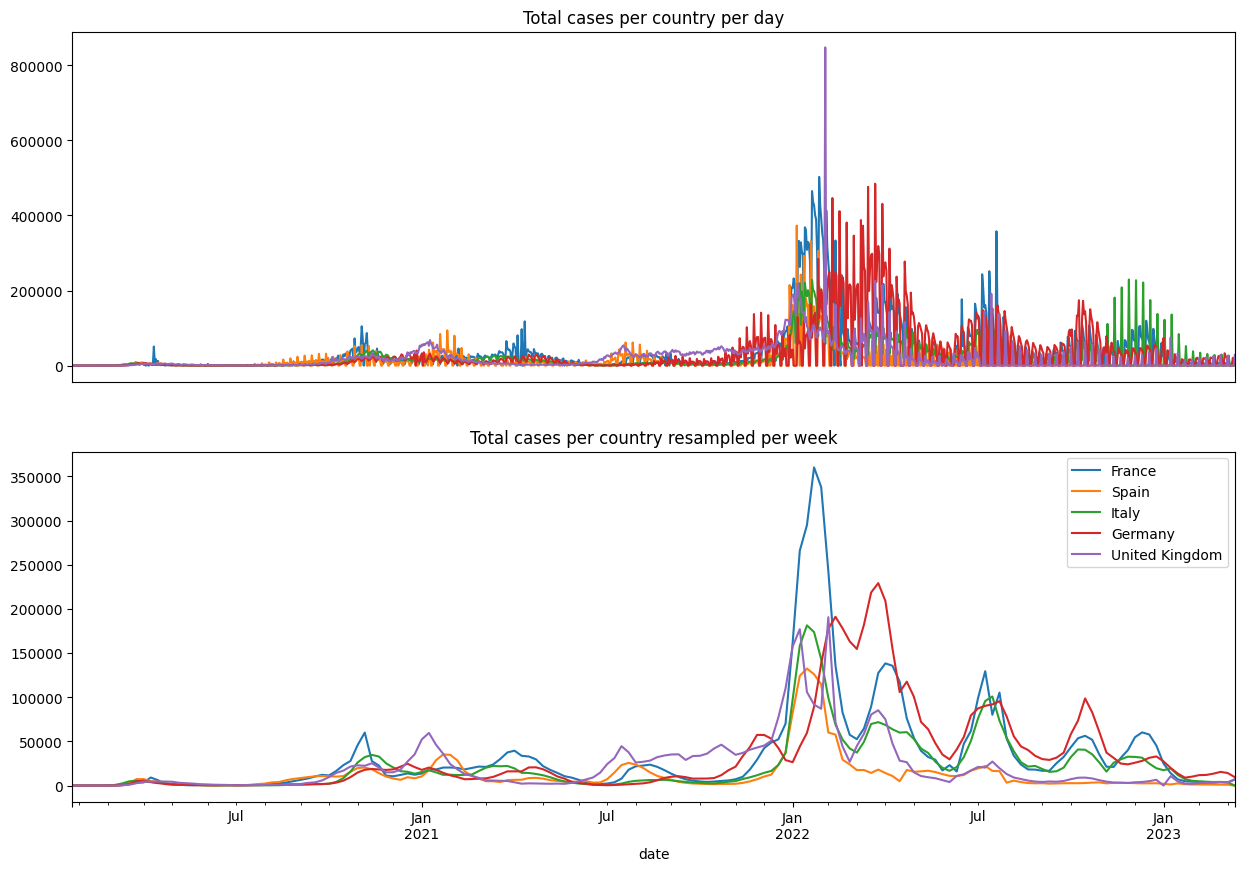

In [126]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))


data_days['France'].plot(ax=ax[0])
data_days['Spain'].plot(ax=ax[0])
data_days['Italy'].plot(ax=ax[0])
data_days['Germany'].plot(ax=ax[0])
data_days['United Kingdom'].plot(ax=ax[0])
ax[0].set_title('Total cases per country per day')
ax[0].get_xaxis().set_visible(False)

data['France'].plot(ax=ax[1])
data['Spain'].plot(ax=ax[1])
data['Italy'].plot(ax=ax[1])
data['Germany'].plot(ax=ax[1])
data['United Kingdom'].plot(ax=ax[1])
ax[1].set_title('Total cases per country resampled per week')

plt.legend()
plt.show()

## AR + diffusion

In [ ]:
from src.ar_diffusion.fit import fit_ar_diffusion
from src.ar_diffusion.predict import predict_ar_diffusion_one_step

In [ ]:
p = 3                   # order of the AR model
tau = 0.001                 # time constant of the diffusion
lambda_reg = 0.0       # regularization parameter
l1 = True               # use L1 regularization (True) or L2 regularization (False)
method = "L-BFGS-B"     # optimization method
X = data.values.T       # data matrix
N, K = X.shape          # N=number of nodes and K=number of time points
scaler = MinMaxScaler() # data normalization
X_norm = scaler.fit_transform(X.T).T

alpha_opt, beta_opt, L_opt, result = fit_ar_diffusion(
    X_norm, p=p, tau=tau, lambda_reg=lambda_reg, l1=l1, method=method
)

print("Optimization result :")
print("Status :", result.message)
print("alpha_opt =", alpha_opt)
print("beta_opt =", beta_opt)
print("Laplace matrix L_opt =", L_opt)


Optimization result :
Status : STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
alpha_opt = [ 1.05080259 -0.3850302  -0.06036881]
beta_opt = 0.32478119483117585
Laplace matrix L_opt = [[ 2.52818951e+01 -1.34667267e+00 -1.41031426e+00 -1.13230859e+00
  -2.47913834e+00 -6.52959409e-01 -1.70196849e+00 -2.91859715e+00
  -1.53317310e-01  8.23395987e-02 -1.41807646e+00  3.85925153e-01
   4.92458862e-01 -7.19209624e-01 -9.73180825e-01 -3.31077372e-01
  -3.32557882e+00 -1.02988738e+00 -3.02663401e+00 -4.79711160e-01
  -1.41820355e+00 -1.63843036e+00]
 [ 2.80874228e-01  8.33688777e+00 -1.73911983e-01 -1.06196296e+00
  -2.30410957e+00 -6.62017329e-01 -1.89597393e-01 -1.88463320e+00
   4.48678301e-01  4.27253011e-01 -5.67025664e-01  1.63432304e+00
   7.76295258e-01  1.03562238e+00  7.10249966e-01 -4.69517460e-01
  -2.89866719e+00 -1.15890565e+00 -2.83903968e+00  5.60382595e-01
   2.46001801e-01 -1.04107874e+00]
 [ 6.45057333e-03 -3.56671377e-01  2.21894543e+01 -6.40006979e-01
  -3.69265076e+0

In [493]:
error = 0
error_t_1 = 0
for i in range(p, K):
    X_pred = predict_ar_diffusion_one_step(X_norm, i, alpha_opt, beta_opt, L_opt, tau, p)
    X_pred = np.maximum(0, X_pred)
    error += np.linalg.norm(X_norm[:, i] - X_pred)
    error_t_1 += np.linalg.norm(X_norm[:, i-1] - X_norm[:, i])
print("Error of prediction (AR+diffusion) :", error/(K-p))
print("Error of prediction (t-1) :", error_t_1/(K-p))


Erreur de prédiction (AR+diffusion) : 0.22621973182906877
Erreur de prédiction (t-1) : 0.2289955486960422


In [ ]:
error_list = []
X = data.values.T
N, K = X.shape
X_train = X[:, :int(0.8 * K)]
X_test = X[:, int(0.8 * K):]

for scaler in [MinMaxScaler(), StandardScaler()]:
    x_train_norm = scaler.fit_transform(X_train.T).T
    x_test_norm = scaler.transform(X_test.T).T
    for p in range(0, 6):
        for tau in [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]:
            for lambda_reg in [0.0, 0.01, 0.1, 1.0, 10.0]:
                for l1 in [True, False]:
                    alpha_opt, beta_opt, L_opt, result = fit_ar_diffusion(
                        x_train_norm, p=p, tau=tau, lambda_reg=lambda_reg, l1=l1, method="L-BFGS-B"
                    )
                    error = 0
                    error_t_1 = 0
                    K_test = x_test_norm.shape[1]
                    for i in range(p, K_test):
                        X_pred = predict_ar_diffusion_one_step(x_test_norm, i, alpha_opt, beta_opt, L_opt, tau, p)
                        error += np.linalg.norm(x_test_norm[:, i] - X_pred)
                        error_t_1 += np.linalg.norm(x_test_norm[:, i-1] - x_test_norm[:, i])
                    error_list.append((error/(K_test-p), {"error_t_1": error_t_1, "p":p, "tau":tau, "lambda_reg":lambda_reg, "l1":l1, 'scaler':scaler}))
                    print("Erreur de prédiction (AR+diffusion) :", 
                          error/(K_test-p), "p =", p, "tau =", tau, "lambda_reg =", lambda_reg, "l1 =", l1, "scaler=", scaler, 
                         "Erreur de prédiction (t-1) :", error_t_1/(K_test-p))
import pickle
with open('error_list_dif+AR.pkl', 'wb') as f:
    pickle.dump(error_list, f)

Erreur de prédiction (AR+diffusion) : 0.8351543028052939 p = 0 tau = 0 lambda_reg = 0.0 l1 = True scaler= MinMaxScaler() Erreur de prédiction (t-1) : 0.29099304410033744
Erreur de prédiction (AR+diffusion) : 0.8351543028052939 p = 0 tau = 0 lambda_reg = 0.0 l1 = False scaler= MinMaxScaler() Erreur de prédiction (t-1) : 0.29099304410033744
Erreur de prédiction (AR+diffusion) : 0.8351543028052939 p = 0 tau = 0 lambda_reg = 0.01 l1 = True scaler= MinMaxScaler() Erreur de prédiction (t-1) : 0.29099304410033744
Erreur de prédiction (AR+diffusion) : 0.8351543028052939 p = 0 tau = 0 lambda_reg = 0.01 l1 = False scaler= MinMaxScaler() Erreur de prédiction (t-1) : 0.29099304410033744
Erreur de prédiction (AR+diffusion) : 0.8351543028052939 p = 0 tau = 0 lambda_reg = 0.1 l1 = True scaler= MinMaxScaler() Erreur de prédiction (t-1) : 0.29099304410033744
Erreur de prédiction (AR+diffusion) : 0.8351543028052939 p = 0 tau = 0 lambda_reg = 0.1 l1 = False scaler= MinMaxScaler() Erreur de prédiction (t-

In [47]:
best = min(error_list, key=lambda x: x[0])
print("Best parameters :", best[1])
print("Best error :", best[0])

Best parameters : {'error_t_1': np.float64(7.667546772409408), 'p': 3, 'tau': 0.001, 'lambda_reg': 0.0, 'l1': True, 'scaler': MinMaxScaler()}
Best error : 0.23045571354025937


Best parameters for each p and tau :


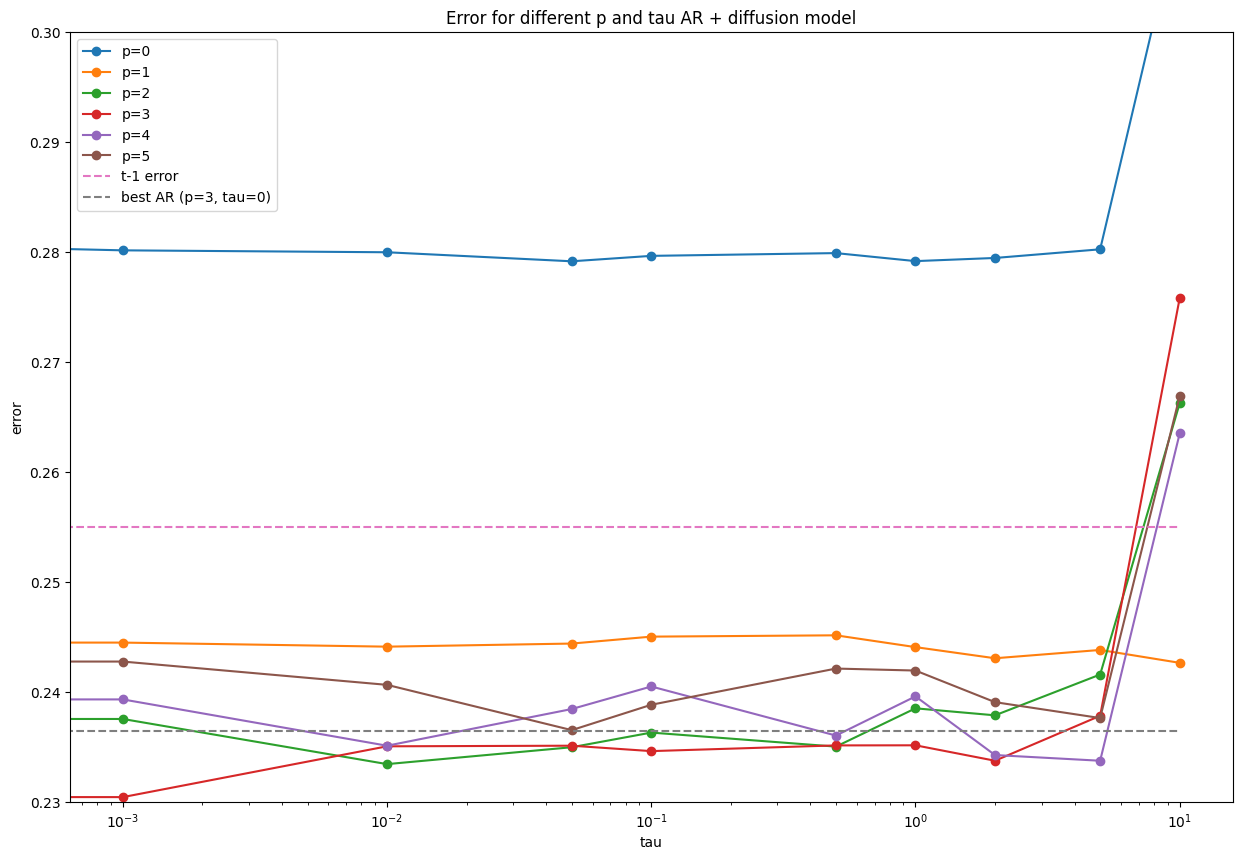

In [ ]:
error_list_best = []
taus = [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
for p in range(0, 6):
    for tau in taus:
        error_list_best.append(sorted([x for x in error_list if x[1]['p'] == p and x[1]['tau'] == tau], key=lambda x: x[0])[0])
        
print("Best parameters for each p and tau :")
plt.figure(figsize=(15, 10))
for p in range(0, 6):
    plt.plot(taus, [x[0] for x in error_list_best if x[1]['p'] == p], label=f"p={p}", marker="o")
    
plt.plot(taus, [0.255]*len(taus), label="t-1 error", linestyle="--")
plt.plot(taus, min([x for x in error_list if x[1]['tau'] == 0], key=lambda x: x[0])[0]*np.ones(len(taus)), label="best AR (p=3, tau=0)", linestyle="--")
plt.xscale("log")
plt.ylim(0.23, 0.3)
plt.xlabel("tau")
plt.ylabel("error")
plt.legend()
plt.title("Error for different p and tau AR + diffusion model")
plt.show()
        
    

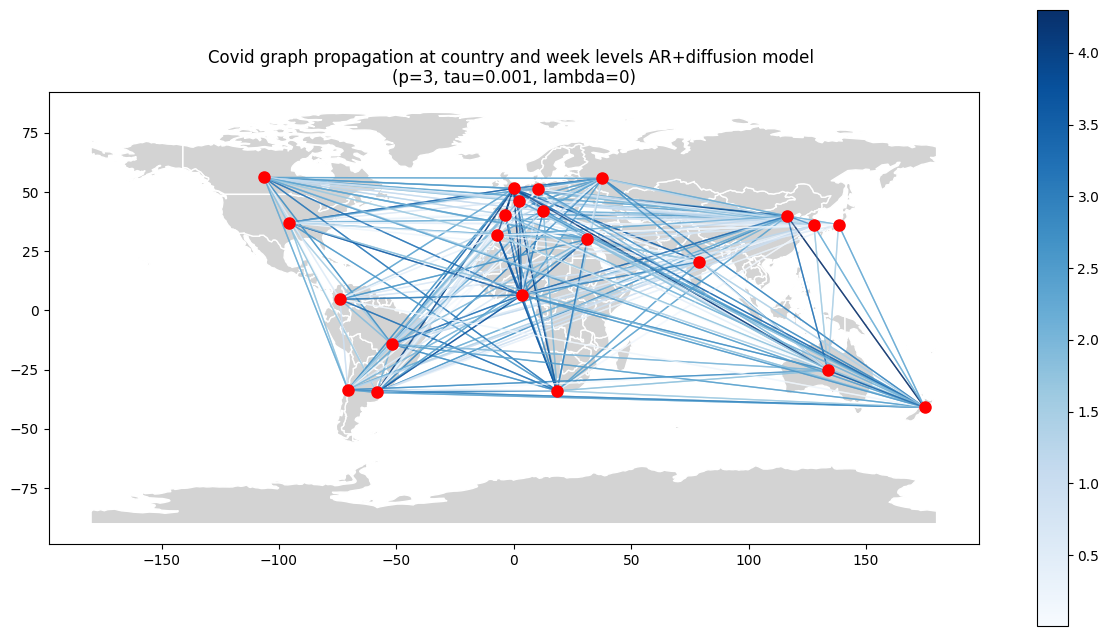

In [111]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

world = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-boundaries-world-110m/master/countries.geojson")

coordinates = {
    'France': (2.2137, 46.2276),
    'Italy': (12.5674, 41.8719),
    'Spain': (-3.7038, 40.4168),
    'Germany': (10.4515, 51.1657),
    'United Kingdom': (-0.1276, 51.5074),
    'Russia': (37.6173, 55.7558),
    'United States': (-95.7129, 37.0902),
    'Canada': (-106.3468, 56.1304),
    'China': (116.4074, 39.9042),
    'Japan': (138.2529, 36.2048),
    'South Korea': (127.7669, 35.9078),
    'India': (78.9629, 20.5937),
    'Brazil': (-51.9253, -14.2350),
    'Argentina': (-58.4173, -34.6037),
    'Colombia': (-74.0721, 4.7110),
    'Chile': (-70.6483, -33.4489),
    'South Africa': (18.4241, -33.9249),
    'Egypt': (31.2357, 30.0444),
    'Nigeria': (3.3792, 6.5244),
    'Morocco': (-7.0926, 31.7917),
    'Australia': (133.7751, -25.2744),
    'New Zealand': (174.8859, -40.9006)
}

L = L_opt

A = -L.copy()
np.fill_diagonal(A, 0)
A = (A + A.T) / 2

countries = list(coordinates.keys())

edges = []
weights = []
for i, country1 in enumerate(countries):
    for j, country2 in enumerate(countries):
        if A[i, j] > 0:
            edges.append(LineString([coordinates[country1], coordinates[country2]]))
            weights.append(A[i, j])

edges_gdf = gpd.GeoDataFrame({'geometry': edges, 'weight': weights}, crs="EPSG:4326")

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
world.plot(ax=ax, color='lightgray', edgecolor='white')


edges_gdf.plot(
    ax=ax,
    column='weight',
    cmap='Blues',
    linewidth=1,
    alpha=0.7,
    legend=True
)

for country, coord in coordinates.items():
    ax.plot(coord[0], coord[1], 'ro', markersize=8)
    # ax.text(coord[0] + 1, coord[1], country, fontsize=10, color='black')

plt.title("Covid graph propagation at country and week levels AR+diffusion model \n(p=3, tau=0.001, lambda=0)")
plt.show()


## SVAR

In [14]:
import numpy as np
from src.svar.fit import estimate_adjacency_matrix_simplified
from src.svar.predict import predict_svar_one_step

In [15]:
# N = number of nodes, K = number of time steps, M = lag order
X = data.values.T
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X.T).T
N, K, M = X_norm.shape[0], X_norm.shape[1], 2
lambda1, lambda2 = 0, 0
tol = 1e-5
max_iter = 300
method = "L-BFGS-B"
lambda1_l1, lambda2_l1 = True, True

# Estimate adjacency matrix and coefficients
A_hat_bis, c_hat_bis = estimate_adjacency_matrix_simplified(X_norm, M, lambda1, lambda2, tol=tol, max_iter=max_iter, method=method,
                                                                            lambda1_l1=lambda1_l1, lambda2_l1=lambda2_l1)

In [16]:
error_algo_simple = 0
error_t_1_algo_simple = 0
for t in range(M, K):
    x_pred = predict_svar_one_step(X_norm[:, t - M:t], A_hat_bis, c_hat_bis)
    x_pred = np.maximum(x_pred, 0)
    error_algo_simple += np.linalg.norm(X_norm[:, t] - x_pred)
    error_t_1_algo_simple += np.linalg.norm(X_norm[:, t] - X_norm[:, t - 1])
print(f"Mean prediction error (Simplified): {error_algo_simple / (K - M):.2f}")
print(f"Mean error (t-1) (Simplified): {error_t_1_algo_simple / (K - M):.2f}")

Mean prediction error (Simplified): 0.17
Mean error (t-1) (Simplified): 0.23


In [23]:
tol = 1e-5
max_iter = 300
method = 'L-BFGS-B'

X = data.values.T
N, K = X.shape
X_train = X[:, :int(0.8 * K)]
X_test = X[:, int(0.8 * K):]

results = []

for scaler in [MinMaxScaler(), StandardScaler()]:
    x_train_norm = scaler.fit_transform(X_train.T).T
    x_test_norm = scaler.transform(X_test.T).T
    for M in [1, 2, 3, 4, 5]: #  Lag order for autoregression.
        for lambda1 in [0, 0.01, 0.1, 1, 10]: # Regularization parameter for adjacency matrix A.
            for lambda2 in [0, 0.01, 0.1, 1, 10]: # Regularization parameter for coefficients c.
                for lambda1_l1 in [True, False]: # Use L1 regularization for adjacency matrix A, false for L2 regularization.
                    for lambda2_l1 in [True, False]: # Use L1 regularization for coefficients c, false for L2 regularization.
                        A_hat, c_hat = estimate_adjacency_matrix_simplified(x_train_norm, M, lambda1, lambda2, 
                                                                            tol=tol, max_iter=max_iter, method=method,
                                                                            lambda1_l1=lambda1_l1, lambda2_l1=lambda2_l1)
                        error = 0
                        error_t_1 = 0
                        K_test = X_test.shape[1]
                        for t in range(M, K_test):
                            x_pred = predict_svar_one_step(x_test_norm[:, t - M:t], A_hat, c_hat)
                            x_pred = np.maximum(x_pred, 0)
                            error += np.linalg.norm(x_test_norm[:, t] - x_pred)
                            error_t_1 += np.linalg.norm(x_test_norm[:, t] - x_test_norm[:, t - 1])
                        error = error / (K_test - M)
                        error_t_1 = error_t_1 / (K_test - M)
                        print(f"Error = {error:.4f}, M = {M} scaler = {scaler}, Lambda1 = {lambda1}, Lambda2 = {lambda2}", 
                              f"lambda1_l1 = {lambda1_l1}, lambda2_l1 = {lambda2_l1}", 
                              f"Error t-1 = {error_t_1:.4f}")
                        results.append({"M": M, "scaler": scaler, "lambda1": lambda1, "lambda2": lambda2, "lambda1_l1": lambda1_l1, 
                                        "lambda2_l1": lambda2_l1, "error": error, "error_t_1": error_t_1, "A_hat": A_hat, "c_hat": c_hat})
                        
with open('results_svar.pkl', 'wb') as f:
    pickle.dump(results, f)

Error = 0.2669, M = 1 scaler = MinMaxScaler(), Lambda1 = 0, Lambda2 = 0 lambda1_l1 = True, lambda2_l1 = True Error t-1 = 0.2539
Error = 0.2656, M = 1 scaler = MinMaxScaler(), Lambda1 = 0, Lambda2 = 0 lambda1_l1 = True, lambda2_l1 = False Error t-1 = 0.2539
Error = 0.2596, M = 1 scaler = MinMaxScaler(), Lambda1 = 0, Lambda2 = 0 lambda1_l1 = False, lambda2_l1 = True Error t-1 = 0.2539
Error = 0.2614, M = 1 scaler = MinMaxScaler(), Lambda1 = 0, Lambda2 = 0 lambda1_l1 = False, lambda2_l1 = False Error t-1 = 0.2539
Error = 0.2617, M = 1 scaler = MinMaxScaler(), Lambda1 = 0, Lambda2 = 0.01 lambda1_l1 = True, lambda2_l1 = True Error t-1 = 0.2539
Error = 0.2665, M = 1 scaler = MinMaxScaler(), Lambda1 = 0, Lambda2 = 0.01 lambda1_l1 = True, lambda2_l1 = False Error t-1 = 0.2539
Error = 0.2666, M = 1 scaler = MinMaxScaler(), Lambda1 = 0, Lambda2 = 0.01 lambda1_l1 = False, lambda2_l1 = True Error t-1 = 0.2539
Error = 0.2653, M = 1 scaler = MinMaxScaler(), Lambda1 = 0, Lambda2 = 0.01 lambda1_l1 = F

In [82]:
best_svar = min(results, key=lambda x: x["error"])
print("Best parameters :", best_svar)

Best parameters : {'M': 4, 'scaler': MinMaxScaler(), 'lambda1': 1, 'lambda2': 1, 'lambda1_l1': False, 'lambda2_l1': True, 'error': np.float64(0.21697020883558862), 'error_t_1': np.float64(0.2578328928016386), 'A_hat': array([[ 0.00000000e+00,  8.46719389e-03,  9.47140547e-03,
         7.66991075e-03,  2.15691377e-02,  6.35655989e-03,
         9.88701215e-03,  2.81219457e-02,  1.99132641e-03,
        -2.06525145e-04,  8.31981807e-03, -3.84450091e-03,
        -6.89545627e-03,  6.76245497e-03, -3.83644774e-03,
        -2.09516738e-04,  2.56702845e-02, -7.07189017e-04,
         2.30217731e-02, -1.54416206e-03,  1.48265715e-02,
         1.97552307e-02],
       [ 6.28960999e-04,  0.00000000e+00,  5.49254203e-03,
         1.42069169e-02,  2.98545821e-02,  9.62066088e-03,
         1.10868957e-02,  2.41377155e-02,  9.83142387e-03,
         2.40860065e-03,  9.59392851e-03, -6.96341468e-03,
        -2.77945948e-03, -1.71204656e-03, -1.28667507e-02,
         1.02599003e-02,  2.84695415e-02,  7.079

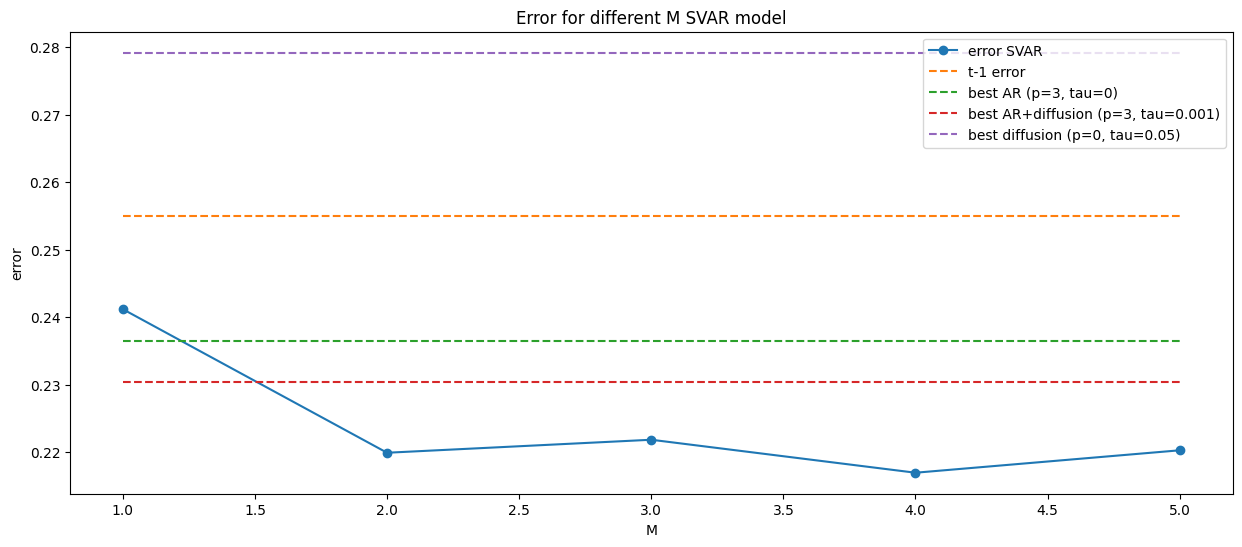

In [106]:
best_for_each_M = []
for M in range(1, 6):
    best_for_each_M.append(min([x for x in results if x["M"] == M], key=lambda x: x["error"]))

plt.figure(figsize=(15, 6))
plt.plot(range(1, 6), [x["error"] for x in best_for_each_M], label="error SVAR", marker="o")
plt.plot(range(1, 6), [0.255]*5, label="t-1 error", linestyle="--")
plt.plot(range(1, 6), min([x for x in error_list if x[1]['tau'] == 0], key=lambda x: x[0])[0]*np.ones(5), label="best AR (p=3, tau=0)", linestyle="--")
plt.plot(range(1, 6), min(error_list, key=lambda x: x[0])[0]*np.ones(5), label="best AR+diffusion (p=3, tau=0.001)", linestyle="--")
plt.plot(range(1, 6), min([x for x in error_list if x[1]["p"] == 0], key=lambda x: x[0])[0]*np.ones(5), label="best diffusion (p=0, tau=0.05)", linestyle="--")
plt.xlabel("M")
plt.ylabel("error")
plt.title("Error for different M SVAR model")
plt.legend()

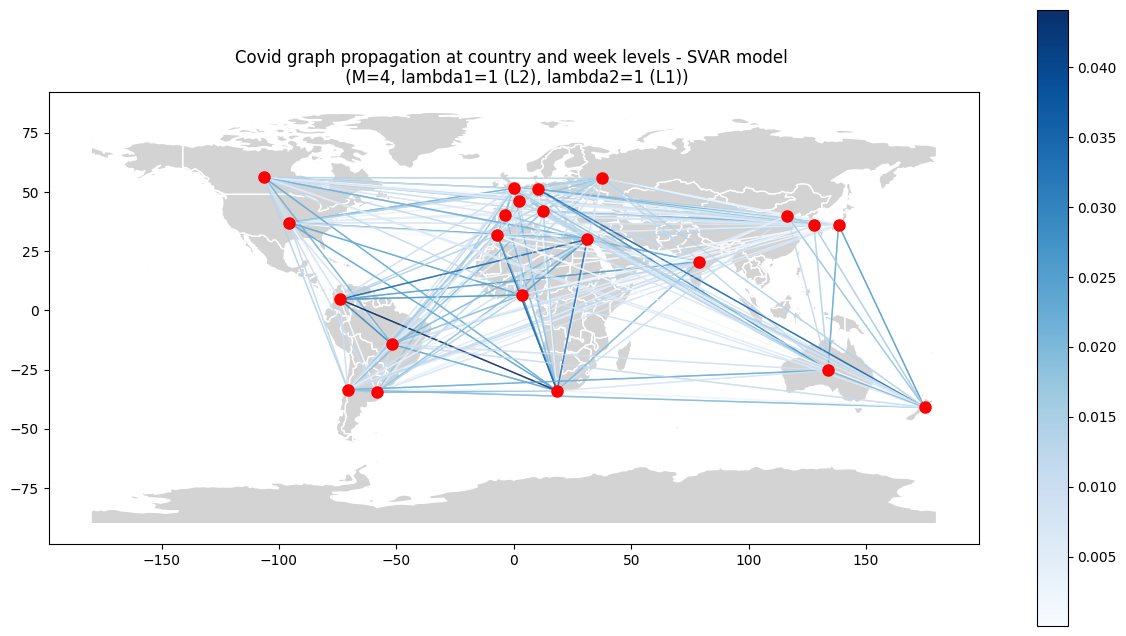

In [ ]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

# Lecture du shapefile "monde"
world = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-boundaries-world-110m/master/countries.geojson")

# Coordonnées des pays
coordinates = {
    'France': (2.2137, 46.2276),
    'Italy': (12.5674, 41.8719),
    'Spain': (-3.7038, 40.4168),
    'Germany': (10.4515, 51.1657),
    'United Kingdom': (-0.1276, 51.5074),
    'Russia': (37.6173, 55.7558),
    'United States': (-95.7129, 37.0902),
    'Canada': (-106.3468, 56.1304),
    'China': (116.4074, 39.9042),
    'Japan': (138.2529, 36.2048),
    'South Korea': (127.7669, 35.9078),
    'India': (78.9629, 20.5937),
    'Brazil': (-51.9253, -14.2350),
    'Argentina': (-58.4173, -34.6037),
    'Colombia': (-74.0721, 4.7110),
    'Chile': (-70.6483, -33.4489),
    'South Africa': (18.4241, -33.9249),
    'Egypt': (31.2357, 30.0444),
    'Nigeria': (3.3792, 6.5244),
    'Morocco': (-7.0926, 31.7917),
    'Australia': (133.7751, -25.2744),
    'New Zealand': (174.8859, -40.9006)
}
A_hat = best_svar['A_hat']
A = A_hat.copy()
np.fill_diagonal(A, 0)
A = (A + A.T) / 2

countries = list(coordinates.keys())

edges = []
weights = []
for i, country1 in enumerate(countries):
    for j, country2 in enumerate(countries):
        if A[i, j] > 0:
            edges.append(LineString([coordinates[country1], coordinates[country2]]))
            weights.append(A[i, j])

edges_gdf = gpd.GeoDataFrame({'geometry': edges, 'weight': weights}, crs="EPSG:4326")

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
world.plot(ax=ax, color='lightgray', edgecolor='white')


edges_gdf.plot(
    ax=ax,
    column='weight',
    cmap='Blues',
    linewidth=1,
    alpha=0.7,
    legend=True
)

for country, coord in coordinates.items():
    ax.plot(coord[0], coord[1], 'ro', markersize=8)
    # ax.text(coord[0] + 1, coord[1], country, fontsize=10, color='black')

plt.title("Covid graph propagation at country and week levels - SVAR model \n (M=4, lambda1=1 (L2), lambda2=1 (L1))")
plt.show()
